### ETAのシミュレーション
自動運転車が道路を走る際、

Strategic（運行前計画） => Tactical（運行時の計画） => Ground（細かいセンシングなど）

の3つのフェーズがある。本研究では2つ目のTacticalフェーズにおける、車両の間隔制御を目的とする。まず、Strategicフェーズでは、だいたい何時頃に何台が到着するかがわかる。それを受けてTacticalフェーズでは実際に道路に到着した車に走路の事前予約（以下、CWP Reservation）を行わせ、その通りに運行する。このシミュレーションはCWP Reservationのアルゴリズムについての研究である。

ここでは大きく3つのオブジェクトが登場する

1. CWPTable: 予約管理をするテーブル
2. Car: 到着時刻に基づきCWPTableに希望時刻を打刻する。
3. Simulation: 帯域密度や到着間隔の管理を行う。

In [2]:
import random
import sys
sys.path.append("../../../")
from simulation_classes.eta.car import Cars
from simulation_classes.eta.CWPTable import CWPTable

In [3]:
# 初期設定（独立変数群）
CAR_NUM = 2 #時間窓内の車の総数
START_TIME = 0
GLOBAL_TIME_WINDOW = 10 # Strategic Phaseでの時間幅
TOTAL_LENGTH = 2000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
SCALE_FACTOR = 20 #シミュレーション上で距離を変換するための係数
TIME_STEP = 1
TOTAL_TIME = 100

# 車のパラメータ
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 5 # 0.5Gくらい
FRONT_BRAKE_REAL_WORLD = 8 # 0.8Gくらい

helly_params = {
    "max_accel":  MAX_ACC_REAL_WORLD / SCALE_FACTOR,
    "min_accel": MIN_ACC_REAL_WORLD / SCALE_FACTOR,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":0.4,
    "response_time":0.5, #秒で入れる,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":False
  }
rss_params = {
    "max_accel":  MAX_ACC_REAL_WORLD / SCALE_FACTOR,
    "min_accel": MIN_ACC_REAL_WORLD / SCALE_FACTOR,
    "front_car_brake":FRONT_BRAKE_REAL_WORLD / SCALE_FACTOR,
    "rear_brake_acc":0.4,
    "response_time":0.5, 
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.499,
    "T_des": 1.1,
    "isRss":True,
  }

# 従属的に決まるもの
SIMULATION_STEPS = int(TOTAL_TIME / TIME_STEP)
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]

arrival_times = sorted([random.uniform(0, GLOBAL_TIME_WINDOW) for _ in range(CAR_NUM)])

CARS = [Cars(arrival_time=time, index=index, mean_speed=MEAN_SPEED, helly_params=helly_params) for index, time in enumerate(arrival_times)]
# for i in range(CAR_NUM):
    

In [8]:
def find_delta_x_list(CARS):
    xcor_list = [car.xcor for car in CARS]
    delta_x_list = [xcor_list[int(i-1)] - xcor_list[int(i)] if i > 0 else 1e4 for i in range(len(xcor_list))]
    return delta_x_list

def find_delta_v_list(CARS):
    v_list = [car.v_x for car in CARS]
    delta_v_list = [v_list[int(i-1)] - v_list[int(i)] if i > 0 else 1e4 for i in range(len(v_list))]
    return delta_v_list

    

In [10]:
# 一旦雑にsimulation開始
cwp_table = CWPTable(waypoints = WAYPOINTS)

for i in range(SIMULATION_STEPS):
    t = i * TIME_STEP
    delta_x_list = find_delta_x_list(CARS)
    delta_v_list = find_delta_v_list(CARS)

    for idx, car in enumerate(CARS):
        # この時間に到着する車がいれば打刻する
        if car.arrival_time >= t and car.arrival_time < t + TIME_STEP:
            desired_list = car.create_desired_list(WAYPOINTS)
            # print(desired_list)
            is_valid = cwp_table.validate(desired_list)
            print(is_valid)
            if is_valid:
                cwp_table.register(desired_list)
            else:
                calibrated_list = cwp_table.calibrate_list(desired_list)
                cwp_table.register(calibrated_list)
            continue
        
        # そうでない車は普通に進む
        delta_x = delta_x_list[idx]
        delta_v = delta_v_list[idx]
        speed = car.decide_speed(TIME_STEP, delta_x, delta_v)
        print("idx:",idx, " speed:",speed)
        # print(delta_x_list)
        print(delta_v_list)

        # delta_xとdelta_vの計算を移動前にやっているので実質pararellになっている
        car.proceed(time_step=TIME_STEP)
        car.record()
            
                


idx: 0  speed: 39.700000000000294
[10000.0, 29.700000000000312]
idx: 1  speed: 9.99999999999998
[10000.0, 29.700000000000312]
初回
True
idx: 1  speed: 10.09999999999998
[10000.0, 29.700000000000315]
idx: 0  speed: 39.800000000000296
[10000.0, 29.600000000000314]
idx: 1  speed: 10.19999999999998
[10000.0, 29.600000000000314]
idx: 0  speed: 39.9000000000003
[10000.0, 29.600000000000314]
idx: 1  speed: 10.29999999999998
[10000.0, 29.600000000000314]
idx: 0  speed: 40.0000000000003
[10000.0, 29.600000000000318]
idx: 1  speed: 10.399999999999979
[10000.0, 29.600000000000318]
idx: 0  speed: 40.1000000000003
[10000.0, 29.60000000000032]
idx: 1  speed: 10.499999999999979
[10000.0, 29.60000000000032]
idx: 0  speed: 40.2000000000003
[10000.0, 29.60000000000032]
idx: 1  speed: 10.599999999999978
[10000.0, 29.60000000000032]
idx: 0  speed: 40.3000000000003
[10000.0, 29.60000000000032]
idx: 1  speed: 10.699999999999978
[10000.0, 29.60000000000032]
idx: 0  speed: 40.400000000000304
[10000.0, 29.600000

In [17]:
df = cwp_table.waypoint_table
print(df[df['car_idx'] == 0])
print(df[df['car_idx'] == 1])
print(CARS[1].arrival_time)

    waypoint_idx       x        eta  car_idx
0              0     0.0    3.89585        0
1              1   200.0   13.89585        0
2              2   400.0   23.89585        0
3              3   600.0   33.89585        0
4              4   800.0   43.89585        0
5              5  1000.0   53.89585        0
6              6  1200.0   63.89585        0
7              7  1400.0   73.89585        0
8              8  1600.0   83.89585        0
9              9  1800.0   93.89585        0
10            10  2000.0  103.89585        0
    waypoint_idx       x         eta  car_idx
0              0     0.0    5.747703        1
1              1   200.0   16.895850        1
2              2   400.0   26.895850        1
3              3   600.0   36.895850        1
4              4   800.0   46.895850        1
5              5  1000.0   56.895850        1
6              6  1200.0   66.895850        1
7              7  1400.0   76.895850        1
8              8  1600.0   86.895850        1


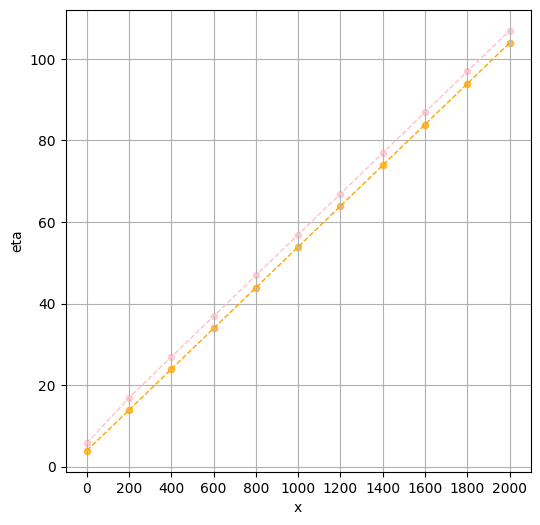

In [18]:
cwp_table.plot()

In [12]:
print(CARS[0].v_xList)

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7, 0.7999999999999999, 0.8999999999999999, 0.9999999999999999, 1.0999999999999999, 1.2, 1.3, 1.4000000000000001, 1.5000000000000002, 1.6000000000000003, 1.7000000000000004, 1.8000000000000005, 1.9000000000000006, 2.0000000000000004, 2.1000000000000005, 2.2000000000000006, 2.3000000000000007, 2.400000000000001, 2.500000000000001, 2.600000000000001, 2.700000000000001, 2.800000000000001, 2.9000000000000012, 3.0000000000000013, 3.1000000000000014, 3.2000000000000015, 3.3000000000000016, 3.4000000000000017, 3.5000000000000018, 3.600000000000002, 3.700000000000002, 3.800000000000002, 3.900000000000002, 4.000000000000002, 4.100000000000001, 4.200000000000001, 4.300000000000001, 4.4, 4.5, 4.6, 4.699999999999999, 4.799999999999999, 4.899999999999999, 4.999999999999998, 5.099999999999998, 5.1999999999999975, 5.299999999999997, 5.399999999999997, 5.4999999999999964, 5.599999999999996, 5.699999999999996, 5.799999999999995, 5.899999999999995, 5.99999